In [171]:
# Import neccessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [172]:
# Load data from local storage into a pandas dataframe
htb = pd.read_csv(r"C:/Users/HP/Documents/Azeez/Hotel Booking Analysis/hotel_bookings_clean.csv")

In [173]:
# Set all columns to show
pd.set_option('display.max_columns', None)
# Preview data
htb.head()

,hotel,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,avg_daily_rate,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,arrival_date,booking_date
0,Resort Hotel,0,342,0,0,2,0,0,Bed & Breakfast,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,No agent,Not provided,0,Transient,0.0,0,0,Check-Out,2015-07-01,2015-07-01,2014-07-24
1,Resort Hotel,0,737,0,0,2,0,0,Bed & Breakfast,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,No agent,Not provided,0,Transient,0.0,0,0,Check-Out,2015-07-01,2015-07-01,2013-06-24
2,Resort Hotel,0,7,0,1,1,0,0,Bed & Breakfast,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,No agent,Not provided,0,Transient,75.0,0,0,Check-Out,2015-07-02,2015-07-01,2015-06-24
3,Resort Hotel,0,13,0,1,1,0,0,Bed & Breakfast,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,Not provided,0,Transient,75.0,0,0,Check-Out,2015-07-02,2015-07-01,2015-06-18
4,Resort Hotel,0,14,0,2,2,0,0,Bed & Breakfast,GBR,Online TA,Travel Agent/Tour Operator,0,0,0,A,A,0,No Deposit,240.0,Not provided,0,Transient,98.0,0,1,Check-Out,2015-07-03,2015-07-01,2015-06-17


In [174]:
# Check datatypes
htb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87396 entries, 0 to 87395
Data columns (total 30 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           87396 non-null  object 
 1   is_canceled                     87396 non-null  int64  
 2   lead_time                       87396 non-null  int64  
 3   stays_in_weekend_nights         87396 non-null  int64  
 4   stays_in_week_nights            87396 non-null  int64  
 5   adults                          87396 non-null  int64  
 6   children                        87396 non-null  int64  
 7   babies                          87396 non-null  int64  
 8   meal                            87396 non-null  object 
 9   country                         87396 non-null  object 
 10  market_segment                  87396 non-null  object 
 11  distribution_channel            87396 non-null  object 
 12  is_repeated_guest               

In [175]:
# Change datatype of columns 'reservation_status_date', 'arrival_date', 'booking_date' to datetime
htb['reservation_status_date'] = pd.to_datetime(htb['reservation_status_date'])
htb['arrival_date'] = pd.to_datetime(htb['arrival_date'])
htb['booking_date'] = pd.to_datetime(htb['booking_date'])

# Re-check datatypes
htb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87396 entries, 0 to 87395
Data columns (total 30 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   hotel                           87396 non-null  object        
 1   is_canceled                     87396 non-null  int64         
 2   lead_time                       87396 non-null  int64         
 3   stays_in_weekend_nights         87396 non-null  int64         
 4   stays_in_week_nights            87396 non-null  int64         
 5   adults                          87396 non-null  int64         
 6   children                        87396 non-null  int64         
 7   babies                          87396 non-null  int64         
 8   meal                            87396 non-null  object        
 9   country                         87396 non-null  object        
 10  market_segment                  87396 non-null  object        
 11  di

***Q1: What is the total revenue generated and how is the trend per month or per year?***

*There is no 'Amount' column*

*But since the Average Daily Rate (adr) is defined as the total stay amount divided by number of nights, we can derive the 'Amount' by xplying 'Adr' with 'Total stay of night'*

In [176]:
# New column: Get total stay night
htb['total_stay_night'] = htb['stays_in_weekend_nights'] + htb['stays_in_week_nights']

# New column: Get total amount per bookings
htb['amount'] = (htb['avg_daily_rate'] * htb['total_stay_night']).round(2)

*Now, in order to get accurate revenue generated, 3 columns must be considered*

1. *is_canceled - for canceled bookings, the amount column is not to be claimed*
2. *deposit_type - for non-refund canceled bookings, the hotel still claims the amount*
3. *reservation_status - only bookings that checkout can be claimed*


In [177]:
# Function to get actual revenue per booking based on 3 conditions
def actual_revenue(row):
    # If reservation status = Check Out
    if row['reservation_status'] == 'Check-Out':
        return row['amount']
    # If reservation status = Canceled but deposit type is Non Refundable
    elif row['reservation_status'] == 'Canceled' and row['deposit_type'] == 'Non Refund':
        return row['amount']  # hotel keeps payment
    # Otherwise return 0
    else:
        return 0

# New column: actual amount realized from booking
htb['revenue'] = htb.apply(actual_revenue, axis=1)

print(f'Total Revenue generated is ${htb['revenue'].sum():,.2f}')

Total Revenue generated is $23,218,556.76


In [342]:
# Create a ordered list of month abbrevations
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Get sum of revenue for each months of the year 
monthly_rev = (htb.groupby([htb['booking_date'].dt.year.rename('year'), # group by year and rename
                            htb['booking_date'].dt.strftime('%b').rename('month')]) # group by year and rename
                            ['revenue'].sum()   # sum revenue
                            .unstack(fill_value=0)  # unstack the 2nd level index and turn to column to be reindex
                            .reindex(columns=month_order)   # re-arrange column using the specified order, filling missing months with value 0
                            .stack()    # stack columns back to rows
                            .reset_index(name='revenue')    # resert_index and turn to a dataframe
                            )

monthly_rev.head(20)

,year,month,revenue
0,2013,Jan,0.00
1,2013,Feb,0.00
2,2013,Mar,0.00
3,2013,Apr,0.00
4,2013,May,0.00
5,2013,Jun,0.00
6,2013,Jul,0.00
7,2013,Aug,0.00
8,2013,Sep,0.00
9,2013,Oct,0.00


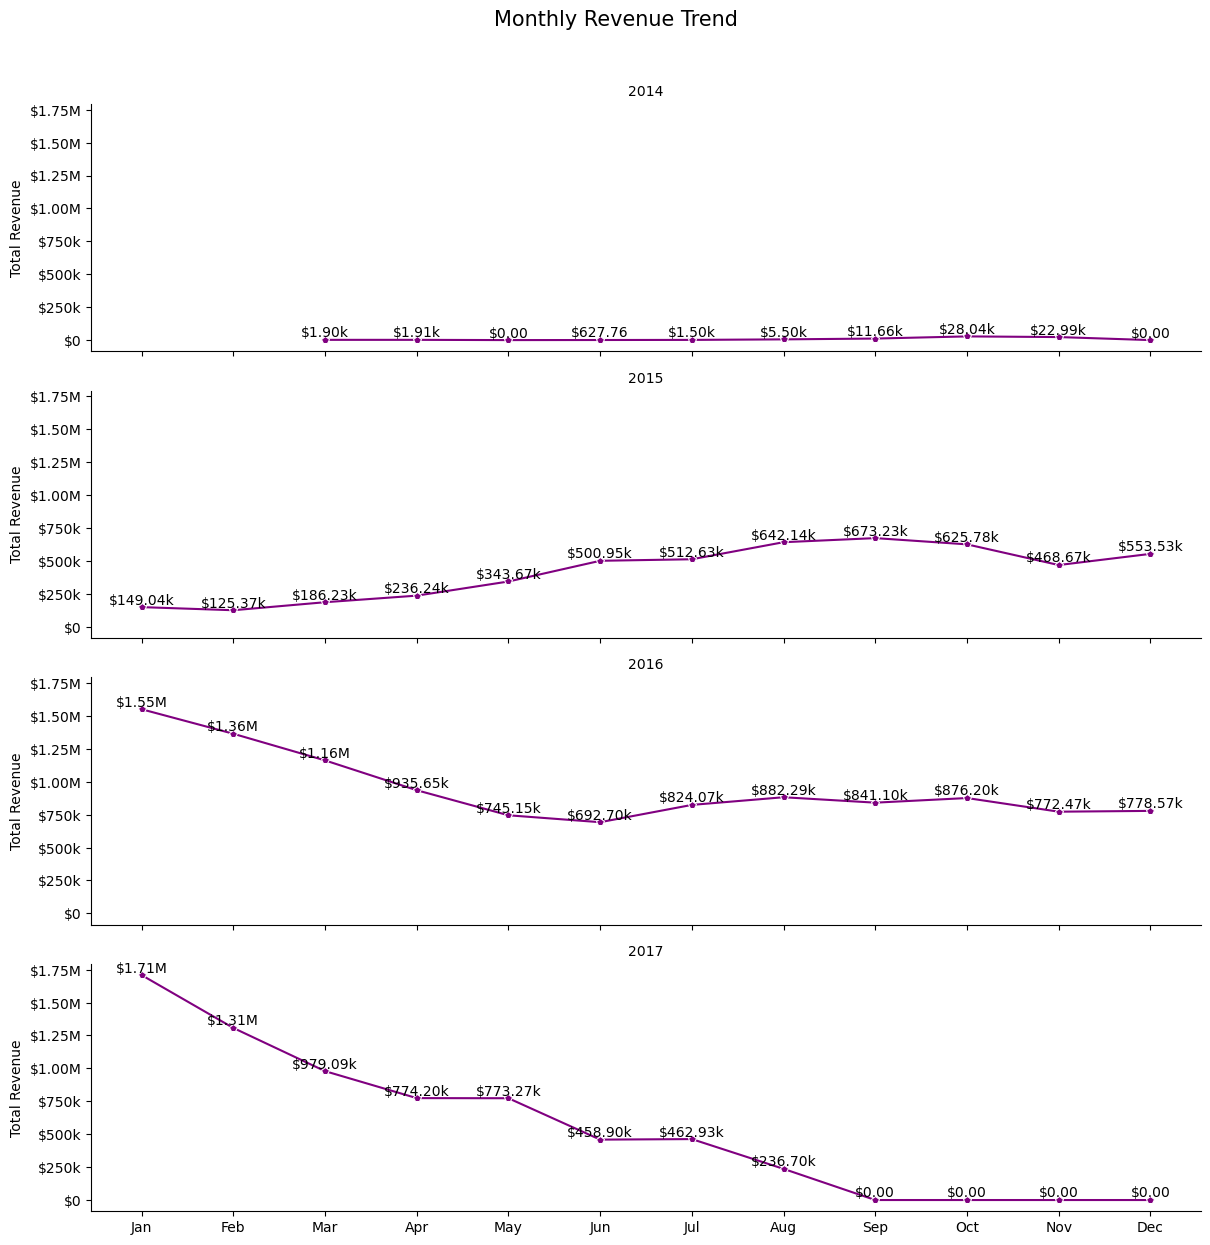

In [ ]:
# Find index of first non-zero revenue to get actual starting point
first_valid_idx = monthly_rev[monthly_rev['revenue'] > 0].index[0]

# Filter from that index onward
monthly_rev = monthly_rev.loc[first_valid_idx:].reset_index(drop=True)

# Make 'month' column categorical type
monthly_rev['month'] = pd.Categorical(monthly_rev['month'], categories=month_order, ordered=True)

# Sort by year and month
monthly_rev = monthly_rev.sort_values(['year','month']).reset_index(drop=True)

# Plot line chart
ax = sns.relplot(data=monthly_rev, kind='line', x='month', y='revenue', row='year', color='purple', marker='p', height=3, aspect=4)

# Loop through each subplot and year data to get axis and values
for a, (year, data_year) in zip(ax.axes.flat, monthly_rev.groupby('year')):
    # Inner loop through month and revenue to add labels
    for mth, rev in zip(data_year['month'], data_year['revenue']):
        a.text(mth, rev, s=f'${rev/1000000:.2f}M' if rev >= 1000000 else (f'${rev/1000:.2f}k' if rev >= 1000 else f'${rev:.2f}'), ha='center', va='bottom')

# Format y-axis ticks
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x/1000000:.2f}M' if x >= 1000000 else (f'${x/1000:.0f}k' if x >= 1000 else f'${x:.0f}')))

# Plot styling
ax.set_xlabels('')
ax.set_ylabels('Total Revenue')
ax.set_titles("{row_name}") # set subplot titles to the value used to split
plt.suptitle('Monthly Revenue Trend', y=1.05, size=15)

plt.show()

***Q2: What proportion of total revenue is generated by Resort vs. City hotels?***

          hotel  total_revenue
0    City Hotel    12353114.96
1  Resort Hotel    10865441.80


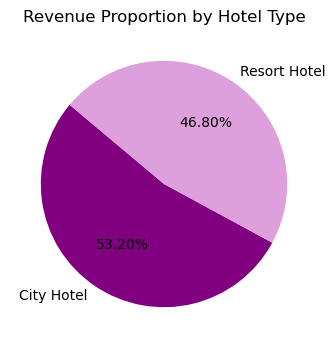

In [357]:
# Get total revenue by hotel type
hotel_rev = htb.groupby('hotel')['revenue'].sum().reset_index(name='total_revenue')
print(hotel_rev)

# Plot pie chart
plt.figure(figsize=(4,4))
plt.pie(hotel_rev['total_revenue'], labels=hotel_rev['hotel'], autopct='%1.2f%%', startangle=140, colors=['purple', 'plum'])
plt.title('Revenue Proportion by Hotel Type')
plt.show()


***Q3: What is the average ADR per hotel type?***

*Note: ADR (Average Daily Rate) reflects actual revenue per night, so only guests who completed their stay (i.e., reservation_status = 'Check-Out') are considered in the calculation.*

In [358]:
# Filter data for only bookings that checked-out
check_outs = htb[htb['reservation_status']=='Check-Out'].copy()

# New column: get total no of stay
check_outs['total_stay'] = check_outs['stays_in_weekend_nights'] + check_outs['stays_in_week_nights']

# Calculate the average daily rate by Hotel type
check_outs.groupby('hotel')['avg_daily_rate'].mean().round(2)

hotel
City Hotel      108.28
Resort Hotel     92.97
Name: avg_daily_rate, dtype: float64

***Q4: How does ADR correlate with length of stay or lead time?***

*Correlation of ADR and Length of Stay*

The correlation of ADR and Length of Stay is 0.05


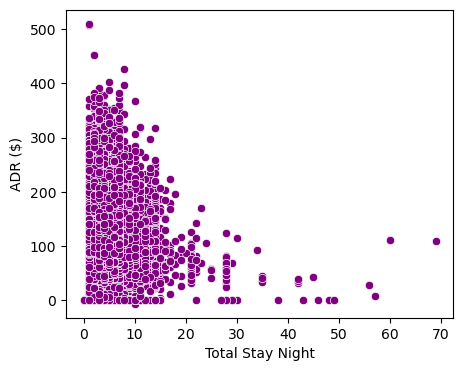

In [363]:
# Print the correlation of ADR and Length of Stay
print(f'The correlation of ADR and Length of Stay is {check_outs['total_stay_night'].corr(check_outs['avg_daily_rate']):.2f}')

plt.figure(figsize=(5,4)) # set plot size

# Plot scatterplot
sns.scatterplot(data=check_outs, x='total_stay_night', y='avg_daily_rate', color='purple')

# Plot styling
plt.ylabel('ADR ($)')
plt.xlabel('Total Stay Night')

plt.show()

*Correlation of ADR and Lead Time*

The correlation of ADR and Length of Stay is 0.03


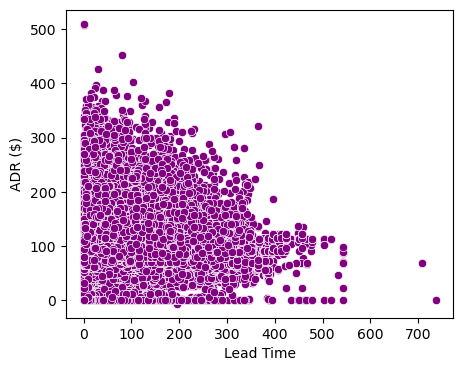

In [364]:
# Print the correlation of ADR and Length of Stay
print(f'The correlation of ADR and Length of Stay is {check_outs['lead_time'].corr(check_outs['avg_daily_rate']):.2f}')

plt.figure(figsize=(5,4))   # set plot size

# Plot scatter plot
sns.scatterplot(data=check_outs, x='lead_time', y='avg_daily_rate', color='purple')

# Plot styling
plt.ylabel('ADR ($)')
plt.xlabel('Lead Time')

plt.show()

***Q5: Which combinations of hotel type × customer type × market segment yield the highest ADR?***

*Note: ADR (Average Daily Rate) reflects actual revenue per night, so only guests who completed their stay (i.e., reservation_status = 'Check-Out') are considered in the calculation.*<br>
*Therefore, we use the **Check-outs** dataframe*

In [361]:
# Get the average daily rate by hotel type × customer type × market segment and get top 10 combination
(check_outs
 .groupby(['hotel', 'customer_type', 'market_segment'])
 ['avg_daily_rate'].mean()
 .nlargest(10)
 .reset_index()
 .round(2)
 )

,hotel,customer_type,market_segment,avg_daily_rate
0,Resort Hotel,Contract,Online TA,134.75
1,City Hotel,Transient,Direct,121.36
2,City Hotel,Transient,Online TA,119.18
3,City Hotel,Group,Direct,111.82
4,City Hotel,Contract,Online TA,111.70
5,Resort Hotel,Transient,Direct,110.63
6,City Hotel,Group,Aviation,110.00
7,City Hotel,Transient-Party,Online TA,109.73
8,City Hotel,Transient-Party,Direct,109.36
9,Resort Hotel,Transient,Online TA,107.77


***Q6: What is the revenue trend by country?***

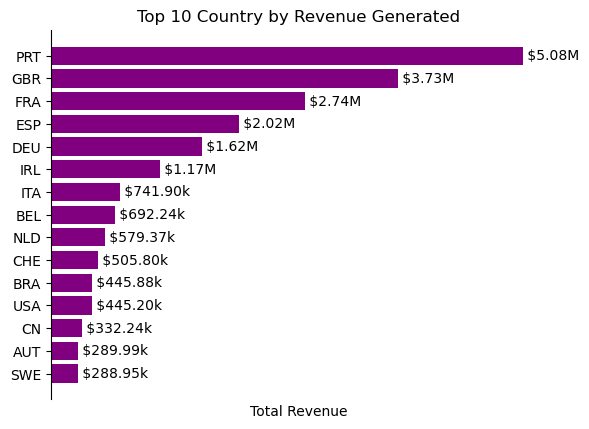

In [365]:
# Get total revenue by country
country_rev = (htb.groupby('country')['revenue'].sum().nlargest(15).sort_values())

# Plot horizontal bar chart
rev_bar = plt.barh(country_rev.index, country_rev.values, color='purple')
plt.bar_label(rev_bar, labels=[f' ${rev/1000000:.2f}M' if rev >= 1000000 else (f' ${rev/1000:.2f}k' if rev >= 1000 else f' ${rev:.2f}') for rev in rev_bar.datavalues])

# Plot styling
plt.xlabel('Total Revenue')
plt.xticks([])
plt.title('Top 10 Country by Revenue Generated')
sns.despine(bottom=True)

plt.show()

***Q7: What percentage of bookings include special requests, and does this relate to ADR?***

In [371]:
# Calculate percentage of bookings with at least one special request
pct_special = (htb['total_of_special_requests'] > 0).mean() * 100
print(f"{pct_special:.2f}% of bookings include at least one special request.")

# Compare ADR by number of special requests using the Check-outs dataframe
special_adr = (check_outs.groupby('total_of_special_requests')
               ['avg_daily_rate'].mean()
               .reset_index()
               .sort_values('total_of_special_requests')
               )

special_adr


49.78% of bookings include at least one special request.


,total_of_special_requests,avg_daily_rate
0,0,91.370018
1,1,106.583298
2,2,118.511237
3,3,125.694839
4,4,132.187413
5,5,130.655294
